# MVP

The goal of this project is analyze the relationship between various features and gross domestic profit for the top 1000 grossing movies that never made it to #1 on the weekend box office. Virtually every weekend box office #1 movie is cut from the same cloth. Half(!) of the top 20 highest domestic grossing movies are either from Star Wars or The Avengers alone. This project is for the dreamers out there who might have a movie script in mind that's not a Super Hero trilogy, who might benefit from learning about trends that the most successful, but not mega-blockbuster movies had. 


To my instructors: Most of this notebook is boring scraping and EDA stuff. Towards the end you can find the first Linear Regression modelling I've done. The R^2 is one of the worst I've seen! Heh, but I learned a lot this week and hopefully can improve these results and incorporate more features. 

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [ ]:
url = 'https://www.boxofficemojo.com/chart/never_in_top/?by_rank_threshold=1&ref_=bo_cso_ac'

response = requests.get(url)
page = response.text

soup = BeautifulSoup(page,"lxml")

table = soup.find('table')
rows = [row for row in table.find_all("tr")]


movies = {}    # dict

for row in rows[1:]:        
    items = row.find_all('td')
    link = items[1].find('a')
    title, url = link.text.split('- Box')[0].strip(), link['href']    # instead of link.text.split('-') 
    movies[title] = [url] + [i.text for i in items]
    
movies

In [ ]:
# now do scroll pages (P2 to P6, up to 1200 movies)

for i in range(200, 801, 200):  
    url = "https://www.boxofficemojo.com/chart/never_in_top/?by_rank_threshold=1&offset={}".format(i)
    
    #print(url)
    
    response = requests.get(url)
    page = response.text

    soup = BeautifulSoup(page,"lxml")
    table = soup.find('table')

    # movie_all ={}  # doesnt need this for dict append 
    rows = [row for row in table.find_all("tr")]


    for row in rows[1:]:        
        items = row.find_all('td')
        link = items[1].find('a')
        title, url = link.text.split('- Box')[0].strip(), link['href']    # instead of link.text.split('-') 
        movies[title] = [url] + [i.text for i in items]
    
print (movies)

In [ ]:
movies_rank = pd.DataFrame(movies).T  #transpose
movies_rank.columns = ['link_stub','Rank','Release','Total_Rank','Top_Rank','Overall_Rank','Year','Distributor']

movies_rank.head()

In [ ]:
movies_rank.tail()

In [ ]:
movies_rank.shape  # should be 1000

In [ ]:
# STEP 1: Create function to grab values
# The text matching method can also help us get runtime, rating, and release date, so let's make a reuable function.

import re

def get_movie_value(soup, field_name):
    
    
    obj = soup.find(text=re.compile(field_name))
    
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    
    if next_element:
        return next_element.text 
    else:
        return None

In [ ]:
# STEP 2: Create helper functions to parse strings into appropriate data types
# The returned values all need a bit of formatting before we can work with this data. Here are a few helper functions.


# data cleaning

import dateutil.parser

def money_to_int(moneystring):                                            
    try:
        moneystring = moneystring.replace('$', '').replace(',', '')
        return moneystring
    except:
        return None
    

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:                                                 
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None



def to_date(datestring):
    
    # try/except to deal with  Parser error. There's probably a better way.
    try:
        date = dateutil.parser.parse(datestring)
        return date
    except:
        return None
    


In [ ]:
def get_movie_dict(link):
    '''
    From BoxOfficeMojo link stub, request movie html, parse with BeautifulSoup, and
    collect 
   
        
    Return information as a dictionary.
    '''
    
    base_url = 'https://www.boxofficemojo.com'
    
    #Create full url to scrape
    url = base_url + link
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['movie_title','distributor',
               'domestic_total_gross','widest','opening','budget',
               'release_date','rating','runtime_minutes','genres']              
    
    #Get title
    title_string = soup.find('title').text
    #title = title_string.replace('-','')[0].strip()   
    title = title_string.split('- Box')[0].strip()   
    
    #Get distributor
    distributor = get_movie_value(soup,'Distributor')
    #distributor = distributor.strip().replace("See full company information", "")
             
    
    #Get domestic gross
    raw_domestic_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    domestic_total_gross = money_to_int(raw_domestic_total_gross)

    #get widest release
    widest_release_value = get_movie_value(soup, "Widest Release")
    widest_release = widest_release_value.replace(",", "").split(" ")[0]
    widest = widest_release_value.strip()
    
    #get opening
    element1 = soup.find(class_="a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile")
    if not element1:
        opening = None
    element2 = element1.find("span", class_="money")
    if not element2:
        opening = None
    else:
        opening = element2.text.replace("$", "").replace(",", "")
    
    
    
    
    
    #Get budget                                              
    raw_budget = get_movie_value(soup,'Budget')
    budget = money_to_int(raw_budget)          
    
    
    #Get release date
    raw_release_date = get_movie_value(soup,'Release Date').split('\n')[0]
    release_date = to_date(raw_release_date)
    
        
    #Get rating
    rating = get_movie_value(soup,'MPAA')
    
    
    #Get runtime
    raw_runtime = get_movie_value(soup,'Running')
    runtime = runtime_to_minutes(raw_runtime)
    
    
    #Get Genres 
              
    genres = get_movie_value(soup,'Genres').split() 
    
    



    
    #Create movie dictionary and return
    movie_dict = dict(zip(headers, [title, 
                                distributor,
                                domestic_total_gross,
                                widest,
                                opening,
                                budget,
                                release_date,
                                rating,
                                runtime,
                                genres
                                ]))  
    return movie_dict

In [ ]:
movies_page_info_list = []

for link in movies_rank.link_stub:
    movies_page_info_list.append(get_movie_dict(link))

In [ ]:
movies_page_info_list 

In [ ]:
movies_df = pd.DataFrame(movies_page_info_list)  #convert list of dict to df
movies_df.set_index('movie_title', inplace=True)

movies_df

In [ ]:
movies = movies_rank.merge(movies_df, left_index=True, right_index=True)

movies

In [ ]:


movies.to_csv('/users/nhuvelle/Documents/Linear_Regression_Project/movies_df.csv') 

In [53]:
movies

,link_stub,Rank,Release,Total_Rank,Top_Rank,Overall_Rank,Year,Distributor,distributor,domestic_total_gross,widest,opening,budget,release_date,rating,runtime_minutes,genres
Sing,/release/rl2103150081/?ref_=bo_cso_table_1,1,Sing,"$270,395,425",2,110,2016,Universal Pictures\n\n,Universal PicturesSee full company information...,270395425,"4,029 theaters",35258145,75000000,2016-12-21,PG,108.0,"[Animation, Comedy, Family, Musical]"
My Big Fat Greek Wedding,/release/rl342132225/?ref_=bo_cso_table_2,2,My Big Fat Greek Wedding,"$241,438,208",2,140,2002,IFC Films\n\n,IFC FilmsSee full company information\n\n,241438208,"2,016 theaters",597362,5000000,NaT,PG,95.0,"[Comedy, Drama, Romance]"
Alvin and the Chipmunks: The Squeakquel,/release/rl1816364545/?ref_=bo_cso_table_3,3,Alvin and the Chipmunks: The Squeakquel,"$219,614,612",3,170,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,219614612,"3,747 theaters",48875415,75000000,2009-12-23,PG,88.0,"[Adventure, Animation, Comedy, Family, Fantasy..."
Alvin and the Chipmunks,/release/rl1799587329/?ref_=bo_cso_table_4,4,Alvin and the Chipmunks,"$217,326,974",2,179,2007,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,217326974,"3,499 theaters",44307417,60000000,2007-12-14,PG,92.0,"[Adventure, Animation, Comedy, Family, Fantasy..."
A Star Is Born,/release/rl2164360705/?ref_=bo_cso_table_5,5,A Star Is Born,"$215,288,866",2,186,2018,Warner Bros.\n\n,Warner Bros.See full company information\n\n,215288866,"3,904 theaters",42908051,36000000,2018-10-05,R,136.0,"[Drama, Music, Romance]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Star,/release/rl1149076993/?ref_=bo_cso_table_196,996,The Star,"$40,852,824",6,"2,123",2017,Sony Pictures Entertainment (SPE)\n\n,Sony Pictures Entertainment (SPE)See full comp...,40852824,"2,976 theaters",9812674,20000000,2017-11-17,PG,86.0,"[Adventure, Animation, Comedy, Family, Fantasy]"
Brewster's Millions,/release/rl575243777/?ref_=bo_cso_table_197,997,Brewster's Millions,"$40,833,132",4,"2,128",1985,Universal Pictures\n\n,Universal PicturesSee full company information...,40833132,"1,521 theaters",9858905,None,1985-05-22,None,102.0,[Comedy]
"Love, Simon",/release/rl2768274945/?ref_=bo_cso_table_198,998,"Love, Simon","$40,826,341",5,"2,129",2018,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,40826341,"2,434 theaters",11756244,17000000,2018-03-16,PG-13,110.0,"[Comedy, Drama, Romance]"
Breakthrough,/release/rl218400257/?ref_=bo_cso_table_199,999,Breakthrough,"$40,713,082",3,"2,131",2019,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,40713082,"2,913 theaters",11282333,14000000,2019-04-17,PG,116.0,"[Biography, Drama]"


In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline

df = pd.read_csv('/users/nhuvelle/Documents/Linear_Regression_Project/movies_df.csv')
df.head()

,Unnamed: 0,link_stub,Rank,Release,Total_Rank,Top_Rank,Overall_Rank,Year,Distributor,distributor,domestic_total_gross,widest,opening,budget,release_date,rating,runtime_minutes,genres
0,Sing,/release/rl2103150081/?ref_=bo_cso_table_1,1,Sing,"$270,395,425",2,110,2016,Universal Pictures\n\n,Universal PicturesSee full company information...,270395425,"4,029 theaters",35258145.0,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']"
1,My Big Fat Greek Wedding,/release/rl342132225/?ref_=bo_cso_table_2,2,My Big Fat Greek Wedding,"$241,438,208",2,140,2002,IFC Films\n\n,IFC FilmsSee full company information\n\n,241438208,"2,016 theaters",597362.0,5000000.0,NaN,PG,95.0,"['Comedy', 'Drama', 'Romance']"
2,Alvin and the Chipmunks: The Squeakquel,/release/rl1816364545/?ref_=bo_cso_table_3,3,Alvin and the Chipmunks: The Squeakquel,"$219,614,612",3,170,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,219614612,"3,747 theaters",48875415.0,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
3,Alvin and the Chipmunks,/release/rl1799587329/?ref_=bo_cso_table_4,4,Alvin and the Chipmunks,"$217,326,974",2,179,2007,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,217326974,"3,499 theaters",44307417.0,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
4,A Star Is Born,/release/rl2164360705/?ref_=bo_cso_table_5,5,A Star Is Born,"$215,288,866",2,186,2018,Warner Bros.\n\n,Warner Bros.See full company information\n\n,215288866,"3,904 theaters",42908051.0,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']"


In [221]:
df.shape

(984, 18)

In [222]:
df

,Unnamed: 0,link_stub,Rank,Release,Total_Rank,Top_Rank,Overall_Rank,Year,Distributor,distributor,domestic_total_gross,widest,opening,budget,release_date,rating,runtime_minutes,genres
0,Sing,/release/rl2103150081/?ref_=bo_cso_table_1,1,Sing,"$270,395,425",2,110,2016,Universal Pictures\n\n,Universal PicturesSee full company information...,270395425,"4,029 theaters",35258145.0,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']"
1,My Big Fat Greek Wedding,/release/rl342132225/?ref_=bo_cso_table_2,2,My Big Fat Greek Wedding,"$241,438,208",2,140,2002,IFC Films\n\n,IFC FilmsSee full company information\n\n,241438208,"2,016 theaters",597362.0,5000000.0,NaN,PG,95.0,"['Comedy', 'Drama', 'Romance']"
2,Alvin and the Chipmunks: The Squeakquel,/release/rl1816364545/?ref_=bo_cso_table_3,3,Alvin and the Chipmunks: The Squeakquel,"$219,614,612",3,170,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,219614612,"3,747 theaters",48875415.0,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
3,Alvin and the Chipmunks,/release/rl1799587329/?ref_=bo_cso_table_4,4,Alvin and the Chipmunks,"$217,326,974",2,179,2007,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,217326974,"3,499 theaters",44307417.0,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
4,A Star Is Born,/release/rl2164360705/?ref_=bo_cso_table_5,5,A Star Is Born,"$215,288,866",2,186,2018,Warner Bros.\n\n,Warner Bros.See full company information\n\n,215288866,"3,904 theaters",42908051.0,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,The Star,/release/rl1149076993/?ref_=bo_cso_table_196,996,The Star,"$40,852,824",6,"2,123",2017,Sony Pictures Entertainment (SPE)\n\n,Sony Pictures Entertainment (SPE)See full comp...,40852824,"2,976 theaters",9812674.0,20000000.0,2017-11-17,PG,86.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
980,Brewster's Millions,/release/rl575243777/?ref_=bo_cso_table_197,997,Brewster's Millions,"$40,833,132",4,"2,128",1985,Universal Pictures\n\n,Universal PicturesSee full company information...,40833132,"1,521 theaters",9858905.0,NaN,1985-05-22,NaN,102.0,['Comedy']
981,"Love, Simon",/release/rl2768274945/?ref_=bo_cso_table_198,998,"Love, Simon","$40,826,341",5,"2,129",2018,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,40826341,"2,434 theaters",11756244.0,17000000.0,2018-03-16,PG-13,110.0,"['Comedy', 'Drama', 'Romance']"
982,Breakthrough,/release/rl218400257/?ref_=bo_cso_table_199,999,Breakthrough,"$40,713,082",3,"2,131",2019,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,40713082,"2,913 theaters",11282333.0,14000000.0,2019-04-17,PG,116.0,"['Biography', 'Drama']"


In [223]:
dfn = df.dropna()

In [224]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 982
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            596 non-null    object 
 1   link_stub             596 non-null    object 
 2   Rank                  596 non-null    object 
 3   Release               596 non-null    object 
 4   Total_Rank            596 non-null    object 
 5   Top_Rank              596 non-null    int64  
 6   Overall_Rank          596 non-null    object 
 7   Year                  596 non-null    int64  
 8   Distributor           596 non-null    object 
 9   distributor           596 non-null    object 
 10  domestic_total_gross  596 non-null    int64  
 11  widest                596 non-null    object 
 12  opening               596 non-null    float64
 13  budget                596 non-null    float64
 14  release_date          596 non-null    object 
 15  rating                5

In [225]:
print(dfn.isna().sum())

Unnamed: 0              0
link_stub               0
Rank                    0
Release                 0
Total_Rank              0
Top_Rank                0
Overall_Rank            0
Year                    0
Distributor             0
distributor             0
domestic_total_gross    0
widest                  0
opening                 0
budget                  0
release_date            0
rating                  0
runtime_minutes         0
genres                  0
dtype: int64


In [226]:
dfn['rating'].unique()

array(['PG', 'R', 'PG-13', 'G'], dtype=object)

In [227]:
del dfn['Total_Rank']
del dfn['Overall_Rank']
del dfn['Rank']
del dfn['Unnamed: 0']
del dfn['link_stub']
del dfn['distributor']

In [228]:
dfn['Distributor'] = dfn['Distributor'].replace({'\n\n':''}, regex=True)

<ipython-input-228-4e6b8432a7fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['Distributor'] = dfn['Distributor'].replace({'\n\n':''}, regex=True)


In [229]:
dfn['Distributor'] = dfn['Distributor'].replace({'\n\n':''}, regex=True)

<ipython-input-229-4e6b8432a7fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['Distributor'] = dfn['Distributor'].replace({'\n\n':''}, regex=True)


In [230]:
dfn['widest'] = dfn['widest'].replace({'theaters':''}, regex=True)

<ipython-input-230-0cb4f38090e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['widest'] = dfn['widest'].replace({'theaters':''}, regex=True)


In [231]:
dfn['widest'] = dfn['widest'].map(str.strip)

<ipython-input-231-64ad8fdbc681>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['widest'] = dfn['widest'].map(str.strip)


In [232]:
dfn['widest'] = dfn['widest'].replace({',':''}, regex=True)

<ipython-input-232-2f06cb4ee3cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['widest'] = dfn['widest'].replace({',':''}, regex=True)


In [233]:
dfn['widest'] = pd.to_numeric(dfn['widest'])

<ipython-input-233-dade98681bfe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['widest'] = pd.to_numeric(dfn['widest'])


In [234]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 982
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Release               596 non-null    object 
 1   Top_Rank              596 non-null    int64  
 2   Year                  596 non-null    int64  
 3   Distributor           596 non-null    object 
 4   domestic_total_gross  596 non-null    int64  
 5   widest                596 non-null    int64  
 6   opening               596 non-null    float64
 7   budget                596 non-null    float64
 8   release_date          596 non-null    object 
 9   rating                596 non-null    object 
 10  runtime_minutes       596 non-null    float64
 11  genres                596 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 60.5+ KB


In [235]:
dfn['release_date'] = pd.to_datetime(dfn['release_date'])

<ipython-input-235-84af5aa56c01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['release_date'] = pd.to_datetime(dfn['release_date'])


In [236]:
def date_to_month(date):
    january = [1]
    february = [2]
    march = [3]
    april = [4]
    may = [5]
    june = [6]
    july = [7]
    august = [8]
    september = [9]
    october = [10]
    november = [11]
    december = [12]
    
    if date.month in january:
        return 'january'
    elif date.month in february:
        return 'february'
    elif date.month in march:
        return 'march'
    elif date.month in april:
        return 'april'
    elif date.month in may:
        return 'may'
    elif date.month in june:
        return 'june'
    elif date.month in july:
        return 'july'
    elif date.month in august:
        return 'august'
    elif date.month in september:
        return 'september'
    elif date.month in october:
        return 'october'
    elif date.month in november:
        return 'november'
    else:
        return 'december'

In [237]:
dfn['month'] = dfn['release_date'].apply(date_to_month)

<ipython-input-237-3a0c7740be93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['month'] = dfn['release_date'].apply(date_to_month)


In [238]:
dfn['profit'] = dfn['domestic_total_gross'] - dfn['budget']
dfn.head()

<ipython-input-238-d0e897748eb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['profit'] = dfn['domestic_total_gross'] - dfn['budget']


,Release,Top_Rank,Year,Distributor,domestic_total_gross,widest,opening,budget,release_date,rating,runtime_minutes,genres,month,profit
0,Sing,2,2016,Universal Pictures,270395425,4029,35258145.0,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']",december,195395425.0
2,Alvin and the Chipmunks: The Squeakquel,3,2009,Twentieth Century Fox,219614612,3747,48875415.0,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",december,144614612.0
3,Alvin and the Chipmunks,2,2007,Twentieth Century Fox,217326974,3499,44307417.0,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",december,157326974.0
4,A Star Is Born,2,2018,Warner Bros.,215288866,3904,42908051.0,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']",october,179288866.0
5,Sherlock Holmes,2,2009,Warner Bros.,209028679,3626,62304277.0,90000000.0,2009-12-25,PG-13,128.0,"['Action', 'Adventure', 'Mystery']",december,119028679.0


In [239]:
dfn['Year'].describe()

count     596.000000
mean     2009.013423
std         6.923822
min      1978.000000
25%      2004.000000
50%      2010.000000
75%      2015.000000
max      2020.000000
Name: Year, dtype: float64

In [240]:
dfn = dfn[dfn['Year'] >= 1980]

In [241]:
dfn['Year'].describe()

count     595.000000
mean     2009.065546
std         6.811612
min      1990.000000
25%      2004.000000
50%      2010.000000
75%      2015.000000
max      2020.000000
Name: Year, dtype: float64

In [242]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import statsmodels.api as sm

sns.set(context='notebook', style='whitegrid', font_scale=1)
from sklearn.metrics import mean_squared_error, mean_absolute_error 

%config InlineBackend.figure_formats = ['svg']  # or svg

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [243]:
dfn.head()

,Release,Top_Rank,Year,Distributor,domestic_total_gross,widest,opening,budget,release_date,rating,runtime_minutes,genres,month,profit
0,Sing,2,2016,Universal Pictures,270395425,4029,35258145.0,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']",december,195395425.0
2,Alvin and the Chipmunks: The Squeakquel,3,2009,Twentieth Century Fox,219614612,3747,48875415.0,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",december,144614612.0
3,Alvin and the Chipmunks,2,2007,Twentieth Century Fox,217326974,3499,44307417.0,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",december,157326974.0
4,A Star Is Born,2,2018,Warner Bros.,215288866,3904,42908051.0,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']",october,179288866.0
5,Sherlock Holmes,2,2009,Warner Bros.,209028679,3626,62304277.0,90000000.0,2009-12-25,PG-13,128.0,"['Action', 'Adventure', 'Mystery']",december,119028679.0


In [244]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 982
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Release               595 non-null    object        
 1   Top_Rank              595 non-null    int64         
 2   Year                  595 non-null    int64         
 3   Distributor           595 non-null    object        
 4   domestic_total_gross  595 non-null    int64         
 5   widest                595 non-null    int64         
 6   opening               595 non-null    float64       
 7   budget                595 non-null    float64       
 8   release_date          595 non-null    datetime64[ns]
 9   rating                595 non-null    object        
 10  runtime_minutes       595 non-null    float64       
 11  genres                595 non-null    object        
 12  month                 595 non-null    object        
 13  profit              

In [246]:
ds = dfn.loc[:,['profit','Year','widest','opening','budget','runtime_minutes']]

In [247]:
sns.pairplot(ds)

<AxesSubplot:>

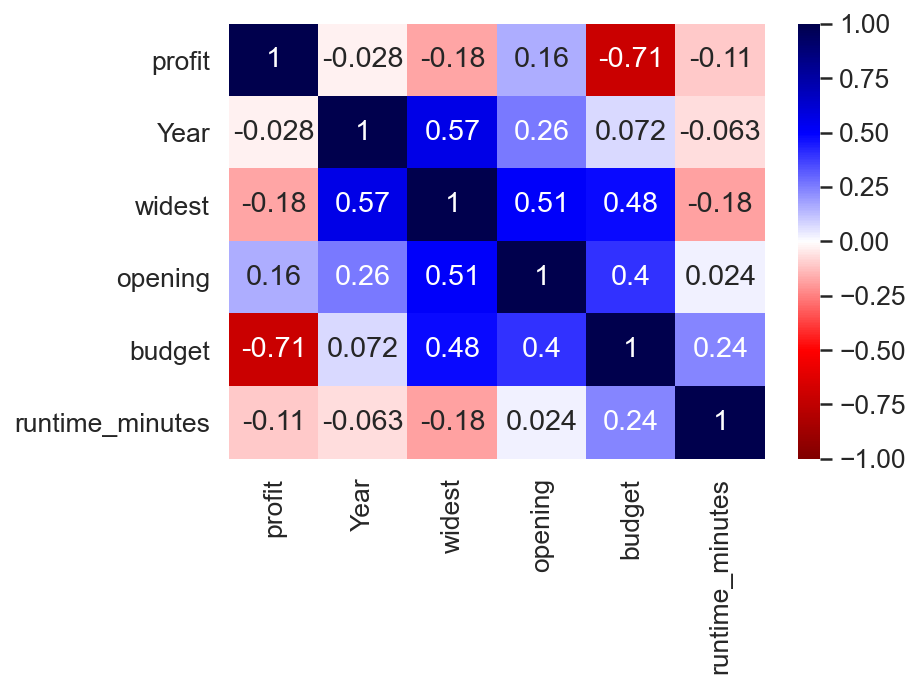

In [106]:
sns.heatmap(ds.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1)

In [144]:
ds.corr()

,profit,Year,widest,opening,budget,runtime_minutes
profit,1.000000,-0.027871,-0.175317,0.159515,-0.705489,-0.106823
Year,-0.027871,1.000000,0.567590,0.257823,0.072142,-0.063012
widest,-0.175317,0.567590,1.000000,0.513297,0.477764,-0.184582
opening,0.159515,0.257823,0.513297,1.000000,0.398501,0.024140
budget,-0.705489,0.072142,0.477764,0.398501,1.000000,0.238653
runtime_minutes,-0.106823,-0.063012,-0.184582,0.024140,0.238653,1.000000


In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [108]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [110]:
# VIF for predictors. Oof Year is high. But we're tight on features and prediction isn't a priority. Let's keep it.
vif(ds.iloc[:, 1:])

Year               116.085592
widest              61.009885
opening              8.801810
budget               4.760716
runtime_minutes     49.687575
dtype: float64

In [248]:
#Separate our features from our target

X = ds.loc[:,['Year','widest','opening','budget', 'runtime_minutes']]

y = ds['profit']

In [249]:
#Create a model using statsmodels
model = sm.OLS(y, sm.add_constant(X)) 

#Fit
fit = model.fit()

#Print out summary. p values look good! We can safely reject the null hypothesis. 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     369.8
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          5.33e-179
Time:                        03:03:41   Log-Likelihood:                -10914.
No. Observations:                 595   AIC:                         2.184e+04
Df Residuals:                     589   BIC:                         2.187e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.301e+09   3.44e+08      6.685      0.000    1.62e+09    2.98e+09
Year            -1.174e+06   1.74e+05     -6.745      0.000   -1.52e+06   -8.32e+05
widest           1.454e+04   2857.514      5.088      0.000    8926.915    2.02e+04
opening             2.6426      0.123     21.471      0.000       2.401       2.884
budget             -1.1086      0.029    -38.137      0.000      -1.166      -1.052
runtime_minutes  3.738e+05   5.93e+04      6.302      0.000    2.57e+05     4.9e+05
==============================================================================
Omnibus:                      267.583   Durbin-Watson:                   1.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1785.516
Skew:                           1.874   Prob(JB):                         0.00
Kurtosis:                      10.614   Cond. No.                     2.80e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [250]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split. 
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
        

In [251]:
split_and_validate(X, y) #slight R^2 dip but not unexpected.


Validation R^2 score was: 0.7261136669336803
Feature coefficient results: 

Year : -1159712.46
widest : 14116.45
opening : 2.70
budget : -1.12
runtime_minutes : 396779.92


In [252]:
# Let's scale the years.
min_year = min(ds['Year']) 
ds['YearX'] = ds['Year'] - min_year  # turn year to age
ds['YearX^2'] = ds['YearX']**2  # polynomial term to add oomph to years. Time is our most scarce resource.

In [253]:
X['Year'] = ds['YearX^2']

#Create a model using statsmodels
model = sm.OLS(y, sm.add_constant(X)) 

#Fit
fit = model.fit()

#Print out summary. That didn't help!
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     360.8
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          1.27e-176
Time:                        03:04:15   Log-Likelihood:                -10920.
No. Observations:                 595   AIC:                         2.185e+04
Df Residuals:                     589   BIC:                         2.188e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.005e+07   1.05e+07     -3.823      0.000   -6.06e+07   -1.95e+07
Year            -2.733e+04   4701.655     -5.813      0.000   -3.66e+04   -1.81e+04
widest           1.242e+04   2820.507      4.403      0.000    6879.723     1.8e+04
opening             2.6231      0.124     21.105      0.000       2.379       2.867
budget             -1.0999      0.029    -37.535      0.000      -1.157      -1.042
runtime_minutes  3.694e+05      6e+04      6.155      0.000    2.52e+05    4.87e+05
==============================================================================
Omnibus:                      269.448   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1802.293
Skew:                           1.889   Prob(JB):                         0.00
Kurtosis:                      10.644   Cond. No.                     8.45e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [254]:
split_and_validate(X, y) #But we knew this


Validation R^2 score was: 0.7211255861974522
Feature coefficient results: 

Year : -27432.16
widest : 12122.76
opening : 2.68
budget : -1.11
runtime_minutes : 394568.26


In [133]:
# win some lose some.
X = ds.loc[:,['YearX','widest','opening','budget', 'runtime_minutes']]

y = ds['profit']

In [134]:
#interactions could be strong here
X2 = X.copy()

# multiplicative interaction
X2['budget*year'] = X2['budget'] * X2['YearX']

# division interaction
X2['budget/runtime_minutes'] = X2['budget'] / X2['runtime_minutes']

split_and_validate(X2, y)


Validation R^2 score was: 0.735582257360218
Feature coefficient results: 

YearX : -1508833.67
widest : 13817.35
opening : 2.74
budget : -1.95
runtime_minutes : 787492.39
budget*year : 0.01
budget/runtime_minutes : 74.27


In [135]:
import scipy.stats as stats

In [136]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

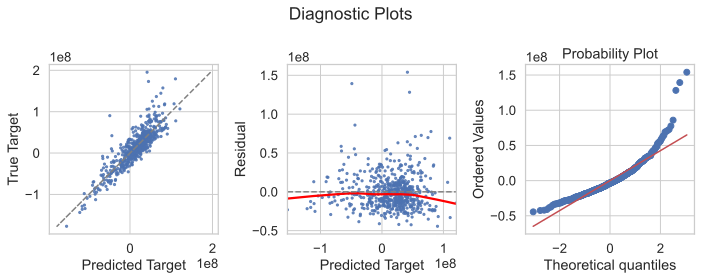

In [139]:
diagnostic_plots(fit.fittedvalues, y, fit.resid)

LinearRegression()

In [154]:
lr.score(XB, y)

0.49771478946190406

In [156]:
#Just checking out budget
model = sm.OLS(y, sm.add_constant(XB)) 

#Fit
fit = model.fit()

#Print out summary. That didn't help!
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     587.6
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           9.95e-91
Time:                        20:49:31   Log-Likelihood:                -11132.
No. Observations:                 595   AIC:                         2.227e+04
Df Residuals:                     593   BIC:                         2.228e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.067e+07   2.31e+06     26.234      0.000    5.61e+07    6.52e+07
x1            -0.7710      0.032    -24.241      0.000      -0.834      -0.709
==============================================================================
Omnibus:                      230.617   Durbin-Watson:                   0.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              868.499
Skew:                           1.796   Prob(JB):                    2.56e-189
Kurtosis:                       7.703   Cond. No.                     1.27e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [206]:
dfn

,Release,Top_Rank,Year,Distributor,domestic_total_gross,widest,opening,budget,release_date,rating,runtime_minutes,genres,month,profit
0,Sing,2,2016,Universal Pictures,270395425,4029,35258145.0,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']",december,195395425.0
2,Alvin and the Chipmunks: The Squeakquel,3,2009,Twentieth Century Fox,219614612,3747,48875415.0,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",december,144614612.0
3,Alvin and the Chipmunks,2,2007,Twentieth Century Fox,217326974,3499,44307417.0,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",december,157326974.0
4,A Star Is Born,2,2018,Warner Bros.,215288866,3904,42908051.0,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']",october,179288866.0
5,Sherlock Holmes,2,2009,Warner Bros.,209028679,3626,62304277.0,90000000.0,2009-12-25,PG-13,128.0,"['Action', 'Adventure', 'Mystery']",december,119028679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,Windtalkers,3,2002,Other,40914068,2898,14520412.0,115000000.0,2002-06-14,R,134.0,"['Action', 'Drama', 'War']",june,-74085932.0
978,Little,2,2019,Universal Pictures,40860481,2667,15405455.0,20000000.0,2019-04-12,PG-13,109.0,"['Comedy', 'Fantasy', 'Romance']",april,20860481.0
979,The Star,6,2017,Sony Pictures Entertainment (SPE),40852824,2976,9812674.0,20000000.0,2017-11-17,PG,86.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",november,20852824.0
981,"Love, Simon",5,2018,Twentieth Century Fox,40826341,2434,11756244.0,17000000.0,2018-03-16,PG-13,110.0,"['Comedy', 'Drama', 'Romance']",march,23826341.0


In [170]:
dfn['rating'].unique()

array(['PG', 'R', 'PG-13', 'G'], dtype=object)

In [199]:
ds

,profit,Year,widest,opening,budget,runtime_minutes
0,195395425.0,2016,4029,35258145.0,75000000.0,108.0
2,144614612.0,2009,3747,48875415.0,75000000.0,88.0
3,157326974.0,2007,3499,44307417.0,60000000.0,92.0
4,179288866.0,2018,3904,42908051.0,36000000.0,136.0
5,119028679.0,2009,3626,62304277.0,90000000.0,128.0
...,...,...,...,...,...,...
975,-74085932.0,2002,2898,14520412.0,115000000.0,134.0
978,20860481.0,2019,2667,15405455.0,20000000.0,109.0
979,20852824.0,2017,2976,9812674.0,20000000.0,86.0
981,23826341.0,2018,2434,11756244.0,17000000.0,110.0


In [200]:
#back to square 1. Taking off the training wheels aka using opening gross as a predictor
X = dfn.loc[:,['Year', 'opening', 'widest', 'budget', 'runtime_minutes']]

y = dfn['profit']

split_and_validate(X, y)


Validation R^2 score was: 0.7261136669335138
Feature coefficient results: 

Year : -1159712.46
opening : 2.70
widest : 14116.45
budget : -1.12
runtime_minutes : 396779.92


In [201]:
print(X)

     Year     opening  widest       budget  runtime_minutes
0    2016  35258145.0    4029   75000000.0            108.0
2    2009  48875415.0    3747   75000000.0             88.0
3    2007  44307417.0    3499   60000000.0             92.0
4    2018  42908051.0    3904   36000000.0            136.0
5    2009  62304277.0    3626   90000000.0            128.0
..    ...         ...     ...          ...              ...
975  2002  14520412.0    2898  115000000.0            134.0
978  2019  15405455.0    2667   20000000.0            109.0
979  2017   9812674.0    2976   20000000.0             86.0
981  2018  11756244.0    2434   17000000.0            110.0
982  2019  11282333.0    2913   14000000.0            116.0

[595 rows x 5 columns]


In [177]:
# Let's add categorical data
X4 = X.copy()

X4['month'] = dfn['month']

split_and_validate(pd.get_dummies(X4, drop_first=True), y)


Validation R^2 score was: 0.8165823261938134
Feature coefficient results: 

Year : -1043878.42
opening : 2.79
widest : 14893.04
budget : -1.15
runtime_minutes : 296888.00
month_august : 6115538.59
month_december : 33014386.56
month_february : 2736011.94
month_january : -122683.77
month_july : 9483865.76
month_june : 10995236.34
month_march : -817462.44
month_may : 6088139.14
month_november : 8709360.35
month_october : -2074617.27
month_september : -1441476.93


In [166]:
# best month: December
# 2nd best: June
# worst: October
# negative months: jan, march, october, september


In [178]:
# Let's add more categorical data
X5 = X4.copy()

X5['rating'] = dfn['rating']

split_and_validate(pd.get_dummies(X5, drop_first=True), y)


Validation R^2 score was: 0.8305548515726445
Feature coefficient results: 

Year : -962783.77
opening : 2.93
widest : 11390.53
budget : -1.17
runtime_minutes : 408148.57
month_august : 7027981.96
month_december : 31562359.68
month_february : 2824893.08
month_january : -2097507.46
month_july : 10083556.54
month_june : 11833496.21
month_march : -255337.32
month_may : 6883714.01
month_november : 7589781.87
month_october : -1780718.06
month_september : -1228740.93
rating_PG : -8237851.00
rating_PG-13 : -20351776.93
rating_R : -20689386.88


In [ ]:
# G movies only positive coeff.

In [186]:
# Distributor doesn't help much
X6 = X5.copy()

X6['Distributor'] = dfn['Distributor']

split_and_validate(pd.get_dummies(X6, drop_first=True), y)


Validation R^2 score was: 0.8257458381427625
Feature coefficient results: 

Year : -926862.08
opening : 2.95
widest : 11301.71
budget : -1.17
runtime_minutes : 418184.66
month_august : 6935289.91
month_december : 31785974.09
month_february : 2567186.45
month_january : -1888753.18
month_july : 10078621.25
month_june : 11899154.08
month_march : -944940.63
month_may : 6677383.29
month_november : 8062418.33
month_october : -2262462.41
month_september : -2057765.24
rating_PG : -9184522.78
rating_PG-13 : -21319958.83
rating_R : -22003654.23
Distributor_Other : 4361842.17
Distributor_Paramount Pictures : -1374978.67
Distributor_Sony Pictures Entertainment (SPE) : -404703.54
Distributor_Twentieth Century Fox : -1152363.87
Distributor_Universal Pictures : -93491.12
Distributor_Walt Disney Studios Motion Pictures : 112597.94
Distributor_Warner Bros. : 2911852.31


In [190]:
dists = dfn['Distributor'].value_counts()
dists

Other                                  122
Twentieth Century Fox                   90
Warner Bros.                            88
Universal Pictures                      83
Sony Pictures Entertainment (SPE)       70
Paramount Pictures                      60
Walt Disney Studios Motion Pictures     57
Lionsgate                               25
Name: Distributor, dtype: int64

In [191]:
other = list(dists[dists<15].index)
dfn['Distributor'] = dfn['Distributor'].replace(other, 'Other')

<ipython-input-191-a337b3d80873>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['Distributor'] = dfn['Distributor'].replace(other, 'Other')


In [189]:
dfn['Distributor'].value_counts()

Other                                  122
Twentieth Century Fox                   90
Warner Bros.                            88
Universal Pictures                      83
Sony Pictures Entertainment (SPE)       70
Paramount Pictures                      60
Walt Disney Studios Motion Pictures     57
Lionsgate                               25
Name: Distributor, dtype: int64

In [194]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric Whoaaa one negative ouch.

array([-0.1527293 ,  0.86727612,  0.86979934,  0.74519056,  0.60684404])

In [163]:
# Hmmmmmmm,, exactly one negative on bothe the 5 and 10 fold? I probably made a mistake somewhere

In [195]:

cross_val_score(lm, X, y, # estimator, features, target
                cv=10, # number of folds 
                scoring='r2') # scoring metric 

array([-0.20611664,  0.58294209,  0.84788125,  0.9034239 ,  0.90751087,
        0.83518701,  0.74254756,  0.79419149,  0.68494647,  0.65335749])

In [ ]:
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score

In [207]:
X = dfn.loc[:,['Year','widest','opening','budget', 'runtime_minutes']]

y = ds['profit']

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures



# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [209]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=10)

In [210]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [211]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.830
Ridge Regression val R^2: 0.831
Degree 2 polynomial regression val R^2: 0.829


In [213]:
pd.get_dummies(dfn['month'], drop_first=True).head()

,august,december,february,january,july,june,march,may,november,october,september
0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0
5,0,1,0,0,0,0,0,0,0,0,0


In [214]:
month_dfn = pd.get_dummies(dfn, drop_first=True) #can just apply it to the whole df
month_dfn.head()

,Top_Rank,Year,domestic_total_gross,widest,opening,budget,release_date,runtime_minutes,profit,Release_13 Hours,...,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
0,2,2016,270395425,4029,35258145.0,75000000.0,2016-12-21,108.0,195395425.0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,2009,219614612,3747,48875415.0,75000000.0,2009-12-23,88.0,144614612.0,0,...,1,0,0,0,0,0,0,0,0,0
3,2,2007,217326974,3499,44307417.0,60000000.0,2007-12-14,92.0,157326974.0,0,...,1,0,0,0,0,0,0,0,0,0
4,2,2018,215288866,3904,42908051.0,36000000.0,2018-10-05,136.0,179288866.0,0,...,0,0,0,0,0,0,0,0,1,0
5,2,2009,209028679,3626,62304277.0,90000000.0,2009-12-25,128.0,119028679.0,0,...,1,0,0,0,0,0,0,0,0,0


In [256]:
X = dfn[['Year', 'opening', 'budget', 'runtime_minutes']]

y = dfn['profit']

In [257]:
lr = LinearRegression()
lr.fit(X, y) 
lr.score(X, y)

0.7477783584852049

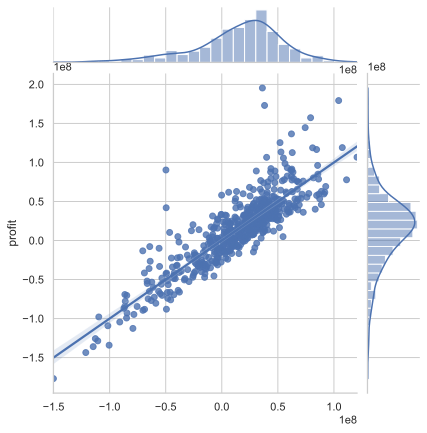

In [258]:
#train and validate but no separate test data (oops!) 
predict = lr.predict(X)  

sns.jointplot(x=predict,y=y, kind='reg')

In [260]:
# Let's add categorical data
X2 = X.copy()

X2['month'] = dfn['month']

split_and_validate(pd.get_dummies(X2, drop_first=True), y)


Validation R^2 score was: 0.8119687897235603
Feature coefficient results: 

Year : -547024.33
opening : 3.03
budget : -1.07
runtime_minutes : 172574.62
month_august : 5865378.52
month_december : 31682273.56
month_february : 52437.36
month_january : -2637983.93
month_july : 7417500.39
month_june : 7776547.08
month_march : -3098429.09
month_may : 3581685.70
month_november : 6499665.81
month_october : -788584.05
month_september : -2149685.75



Validation R^2 score was: 0.8119687897235603
Feature coefficient results: 

Year : -547024.33
opening : 3.03
budget : -1.07
runtime_minutes : 172574.62
month_august : 5865378.52
month_december : 31682273.56
month_february : 52437.36
month_january : -2637983.93
month_july : 7417500.39
month_june : 7776547.08
month_march : -3098429.09
month_may : 3581685.70
month_november : 6499665.81
month_october : -788584.05
month_september : -2149685.75


TypeError: object of type 'NoneType' has no len()

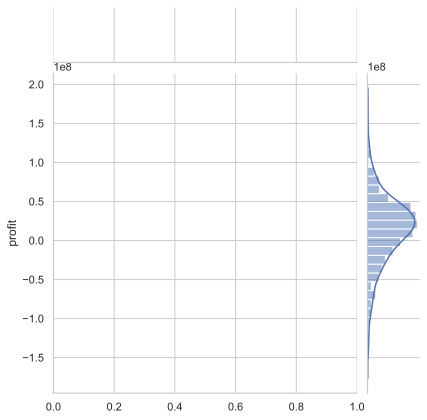

In [263]:
#train and validate but no separate test data (oops!) 
predict = lr.predict(X)  

sns.jointplot(x=split_and_validate(pd.get_dummies(X2, drop_first=True), y),y=y, kind='reg')

In [212]:
month = pd.get_dummies(dfn['month'], drop_first=True)
month.head()

,august,december,february,january,july,june,march,may,november,october,september
0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0
5,0,1,0,0,0,0,0,0,0,0,0
